In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

def prepare_data(ticker, start_date, end_date):
    # Fetch data
    df = yf.download(ticker, start=start_date, end=end_date)
    
    # Feature Engineering: Technical Indicators
    df['Returns'] = df['Close'].pct_change()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['RSI'] = 100 - (100 / (1 + df['Returns'].rolling(14).mean() / df['Returns'].rolling(14).std()))
    
    # Target Label: 1 if price goes UP tomorrow, 0 if DOWN
    df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    
    return df.dropna()

In [3]:
#Signal Evaluation

# 1. Setup Data
data = prepare_data("AAPL", "2020-01-01", "2025-01-01")
features = ['SMA_10', 'SMA_50', 'RSI', 'Returns']
X = data[features]
y = data['Target']

# 2. Time-Series Split (Crucial: Don't shuffle stock data!)
split = int(len(data) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 3. Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 4. Generate Signal Predictions
predictions = model.predict(X_test)

[*********************100%***********************]  1 of 1 completed


In [4]:
#Evaluation

print(classification_report(y_test, predictions))

# Feature Importance
importances = pd.Series(model.feature_importances_, index=features)
print("Top Signaling Factors:\n", importances.sort_values(ascending=False))

              precision    recall  f1-score   support

           0       0.42      0.82      0.55       103
           1       0.54      0.16      0.24       139

    accuracy                           0.44       242
   macro avg       0.48      0.49      0.40       242
weighted avg       0.49      0.44      0.38       242

Top Signaling Factors:
 Returns    0.271049
RSI        0.249965
SMA_10     0.241449
SMA_50     0.237538
dtype: float64


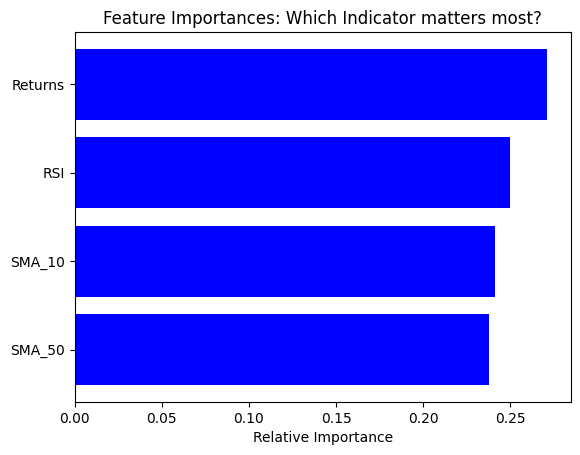

In [5]:
import matplotlib.pyplot as plt

# 1. Getting the importance scores
importances = model.feature_importances_

# 2. Sorting
indices = np.argsort(importances)

# 3. Plotting
plt.title('Feature Importances: Which Indicator matters most?')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()